In [1]:
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import re 
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Twitter API Credentials
BEARER_TOKEN='AAAAAAAAAAAAAAAAAAAAAMoG2AEAAAAAMk%2FyMxKc6IECtN6RrXXMT872emU%3D656uzbQuXl2okjkmZJnvryP9BG0KWlHxqt5JQU14KkC38NemyX'
API_KEY='2Q6DdQ6HtoBN5f78mqAI1fTnE'
API_SECRET='Z4k2QI65f983fSb5kcMVdX7O8F8MHaYJQppobaHGYGEZHJjYz3'
ACCESS_TOKEN='1206042916382052353-yltMEcB65dkMdQQGSF4W78tYZQKPlt'
ACCESS_SECRET='FdfMsmDmN77uCoL3Ry6nATqohkRA2VnOa1CnbMRbCjwxb'

#Authentication with tweepy
auth=tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api=tweepy.API(auth, wait_on_rate_limit=True)
import tweepy


In [ ]:
#Twitter API V2 Authenication 
client=tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAMoG2AEAAAAAMk%2FyMxKc6IECtN6RrXXMT872emU%3D656uzbQuXl2okjkmZJnvryP9BG0KWlHxqt5JQU14KkC38NemyX')
#Define query and fetch tweets
query="(data science OR data analysis OR artificialintelligence) is : retweet"
tweets=client.search_recent_tweets(
    query=query,
    max_results=50,
    tweet_fields=["created_at", "public_metrics", "source"],
    expansions=["author_id"],
    user_fields=["location"]
)


In [ ]:
#Step 2: Map Author_id to user object
users={}
if "users" in tweets.includes:
    users={u.id: u for u in tweets.includes["users"]}

#Step 3 : Extract Data 
tweet_list=[]
for tweet in tweets.data:
    user= users.get(tweet.author_id)
    location=user.location if user and "location" in user .data else None
    tweet_list.append([
        tweet.created_at,
        tweet.id,
        tweet.text,
        tweet.source,
        location,
        tweet.public_metrics["like_count"],
        tweet.public_metrics["retweet_count"]
    ])

#Step 4: Convert to DataFrame
df=pd.DataFrame(tweet_list, columns=["Date", "Tweet ID", "Content", "Source", "Location", "Likes", "Retweet"])
print(df.head())

In [ ]:
#Save data to CSV
df.to_csv("mytweetsdata.csv", index=False, encoding="utf-8")
print("Tweets saved Successfully to tweets_data.csv")


In [2]:
#Load the Dataset
file_path='mytweetsdata.csv'
df=pd.read_csv(file_path)
print(df)

                         Date             Tweet ID  \
0   2025-05-27 04:29:46+00:00  1927220663162474808   
1   2025-05-27 04:29:45+00:00  1927220658263499244   
2   2025-05-27 04:29:41+00:00  1927220641993781705   
3   2025-05-27 04:29:38+00:00  1927220626630062115   
4   2025-05-27 04:29:12+00:00  1927220517620047899   
5   2025-05-27 04:28:44+00:00  1927220401295245380   
6   2025-05-27 04:27:45+00:00  1927220152564588765   
7   2025-05-27 04:27:44+00:00  1927220151402819638   
8   2025-05-27 04:27:27+00:00  1927220077494960577   
9   2025-05-27 04:27:05+00:00  1927219984821801223   
10  2025-05-27 04:26:38+00:00  1927219871651143699   
11  2025-05-27 04:26:27+00:00  1927219829225804260   
12  2025-05-27 04:26:18+00:00  1927219788574609904   
13  2025-05-27 04:26:01+00:00  1927219717908910254   
14  2025-05-27 04:25:49+00:00  1927219667061420444   
15  2025-05-27 04:25:22+00:00  1927219555371204791   
16  2025-05-27 04:25:12+00:00  1927219513449140628   
17  2025-05-27 04:25:03+00:0

In [5]:
#Display basic Info
def explore_data(df):
    print("Dataset Info:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())
explore_data(df)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      50 non-null     object 
 1   Tweet ID  50 non-null     int64  
 2   Content   50 non-null     object 
 3   Source    0 non-null      float64
 4   Location  25 non-null     object 
 5   Likes     50 non-null     int64  
 6   Retweet   50 non-null     int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.9+ KB
None

Sample Data:
                        Date             Tweet ID  \
0  2025-05-27 04:29:46+00:00  1927220663162474808   
1  2025-05-27 04:29:45+00:00  1927220658263499244   
2  2025-05-27 04:29:41+00:00  1927220641993781705   
3  2025-05-27 04:29:38+00:00  1927220626630062115   
4  2025-05-27 04:29:12+00:00  1927220517620047899   

                                             Content  Source  \
0  RT @ECOWARRIORSS: Decommissioned, retired, pau...     NaN   
1  RT

In [7]:
#Clean Text Dataa
def clean_text(Content):
    text=Content.lower()
    text=re.sub(r'http\S+','',Content)
    text=re.sub(r'@\w+','',Content)
    text=re.sub(r'#','',Content)
    text=re.sub(r'[^a-zA-Z]','',Content)
    words=word_tokenize(Content)
    words=[word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)
#Apply text Cleaning 
df['cleaned_text']=df['Content'].astype(str).apply(clean_text)

In [9]:
#Perform Sentiment Analysis
def get_sentiment(text):
    analysis=TextBlob(text)
    polarity=analysis.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
df['Sentiment']=df['cleaned_text'].apply(get_sentiment)

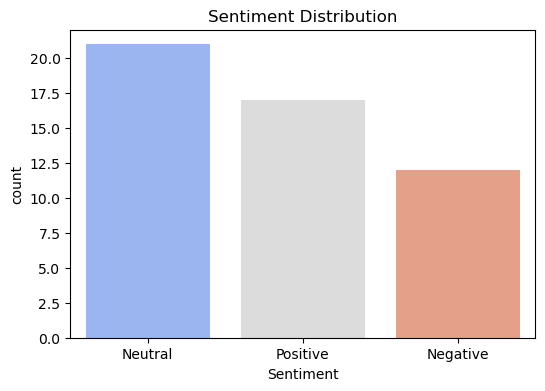

In [11]:
#Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment', palette='coolwarm', hue='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

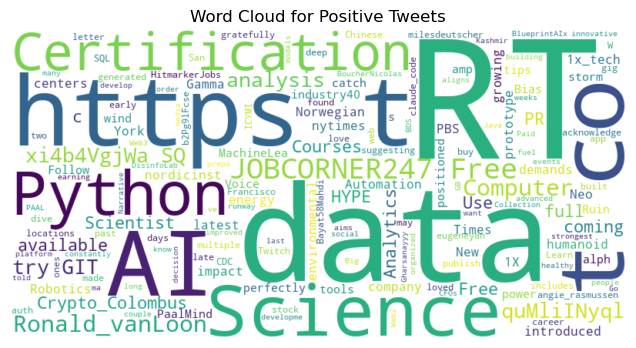

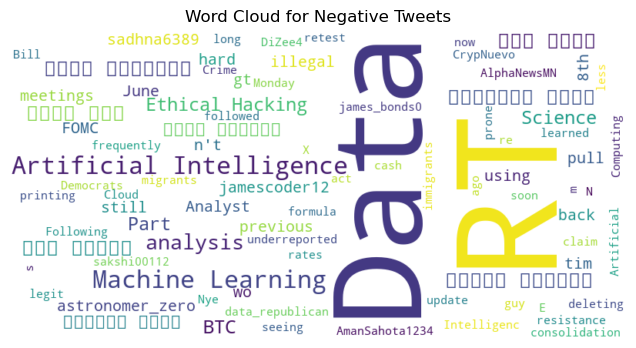

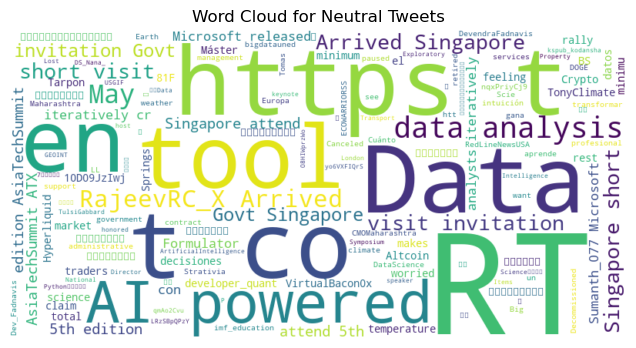

In [13]:
#WordCloud for each Sentiment
def generate_wordcloud(sentiment):
    text=' '.join(df[df['Sentiment']==sentiment]['cleaned_text'])
    wordcloud= WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Tweets')
    plt.show()
generate_wordcloud('Positive')
generate_wordcloud('Negative')
generate_wordcloud('Neutral')

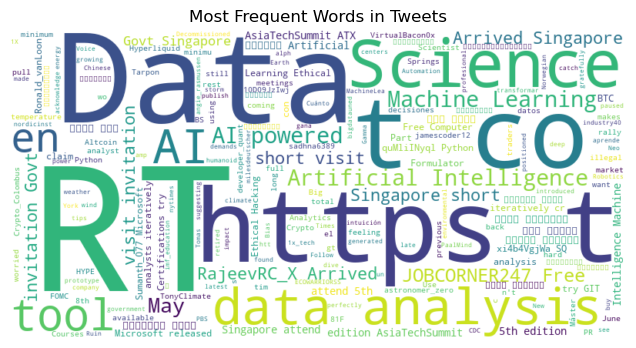

In [14]:
#Most frequent words wordcloud
text=' '.join(df['cleaned_text'])
wordcloud=WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets")
plt.show()

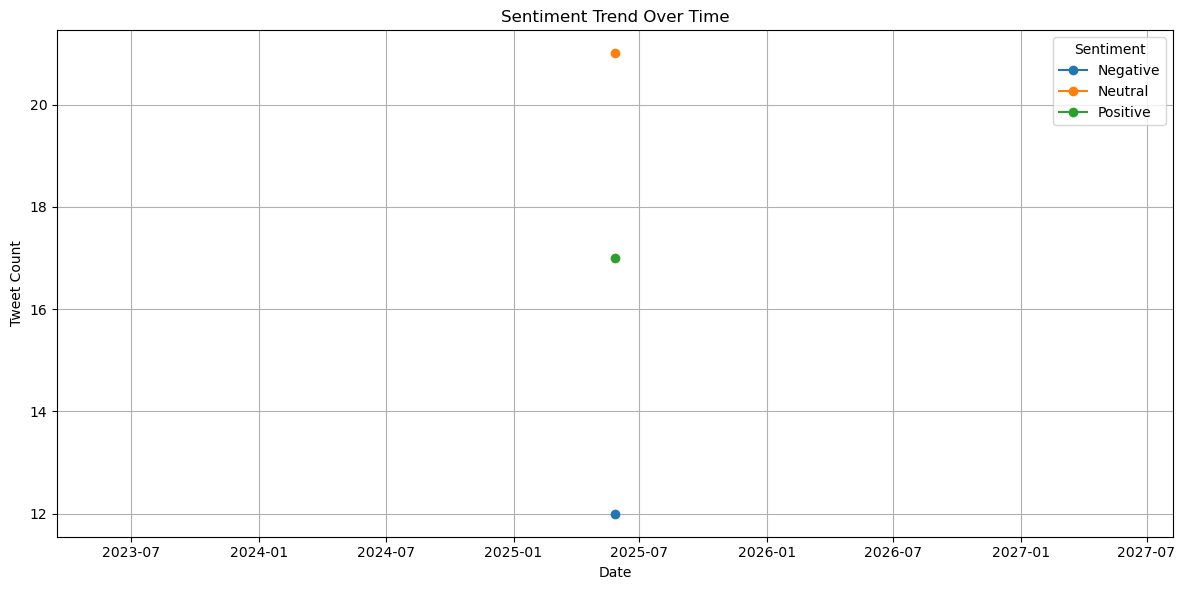

In [15]:
#Time Series Analysis: Sentiment trends over time using 'Date' column
if 'Date' in df.columns and 'Sentiment' in df.columns:
    df['Date']=pd.to_datetime(df['Date'], errors='coerce')
    sentiment_trend=df.groupby([df['Date'].dt.date,'Sentiment']).size().unstack().fillna(0)
    sentiment_trend.plot(kind='line', figsize=(12,6), marker='o')
    plt.title("Sentiment Trend Over Time")
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.legend(title='Sentiment')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found in dataset")

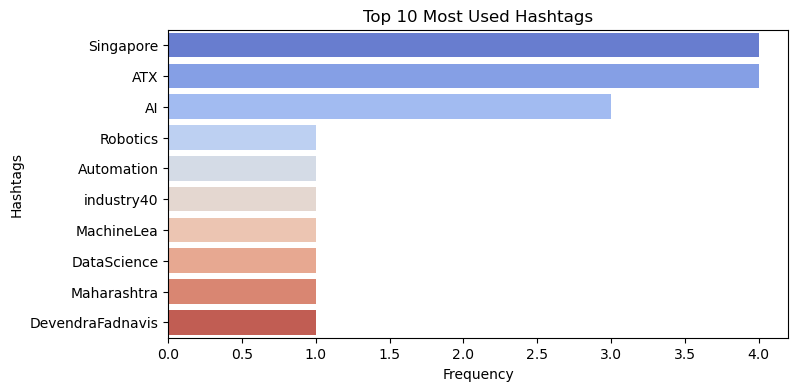

In [17]:
#HashTags
def extract_hashtags(Content):
    return re.findall(r'#(\w+)', Content)
df['hashtags']= df['Content'].apply(extract_hashtags)
all_hashtags= sum(df['hashtags'],[])
hashtags_freq= pd.Series(all_hashtags).value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=hashtags_freq.values, y=hashtags_freq.index, hue=hashtags_freq.index, palette='coolwarm', legend=False)
plt.title("Top 10 Most Used Hashtags")
plt.xlabel('Frequency')
plt.ylabel('Hashtags')
plt.show()

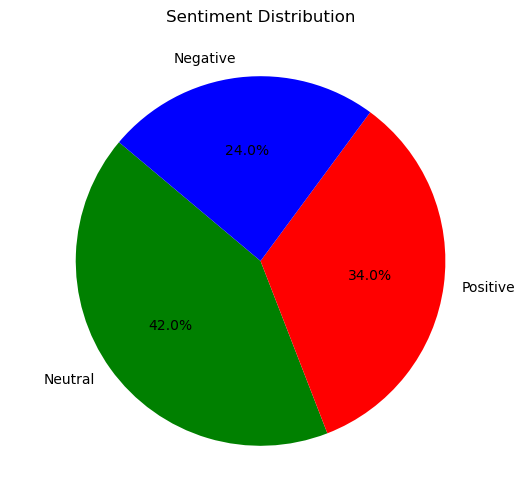

In [19]:
#Pie Chart : Sentiment distribution 
plt.figure(figsize=(6,6))
df['Sentiment'].value_counts().plot.pie(autopct='%1.1f%%',colors=['green','red','blue'],startangle=140)
plt.title('Sentiment Distribution')
plt.ylabel(' ')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report

In [25]:
#Convert sentiment labels into numeric
df=df[df['Sentiment'] != 'Neutral']
df['label'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})
#Text Vectorization 
tfidf=TfidfVectorizer(max_features=3000)
X=tfidf.fit_transform(df['cleaned_text'])
y=df['label']
#Train Test Split 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Define Models
models={
"K-Nearest Neighbors": KNeighborsClassifier(),
"Suppoprt Vector Machine": LinearSVC(),
"Naive Bayes": MultinomialNB(),
"Logistic Regression": LogisticRegression(max_iter=200),
"Desicion Tree": DecisionTreeClassifier(),
"Random Forest": RandomForestClassifier(n_estimators=100)
}

In [61]:
#Train, Predict, and Evaluate
fitted_models={}
for name, model in models.items():
    print(f'\n{name} Results:')
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    fitted_models[name]= model



K-Nearest Neighbors Results:
Accuracy:  0.8333333333333334
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         1
    Positive       1.00      0.80      0.89         5

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6


Suppoprt Vector Machine Results:
Accuracy:  1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
    Positive       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


Naive Bayes Results:
Accuracy:  1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
    Positive       1.00      1.00      1.00         5

    accuracy                        

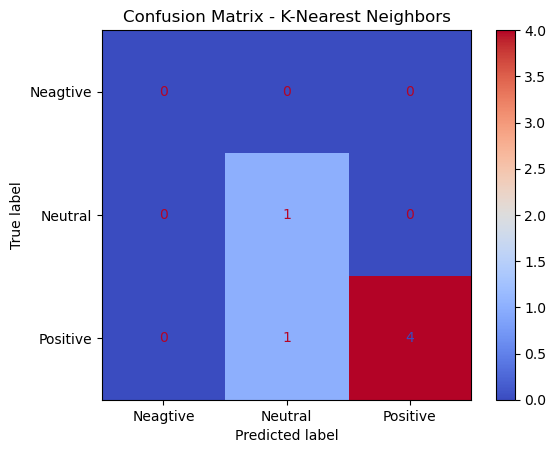

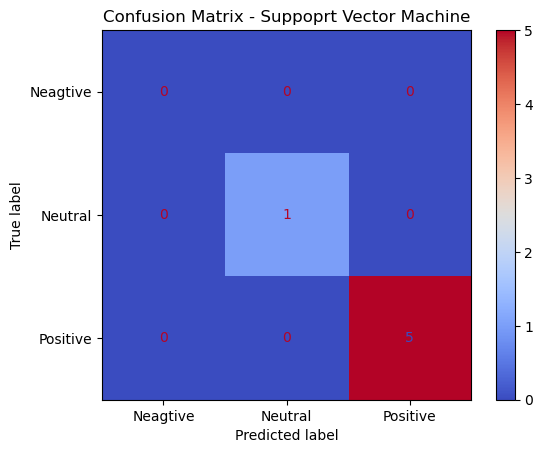

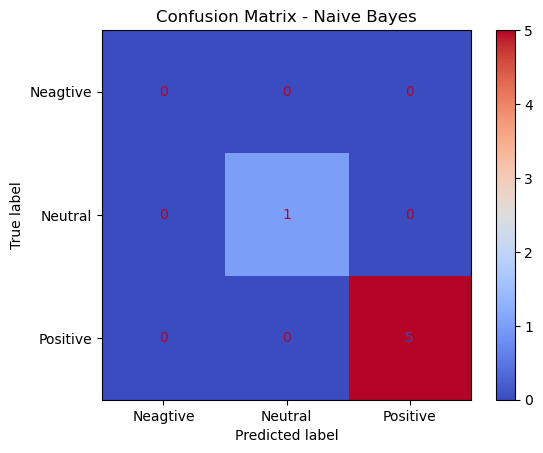

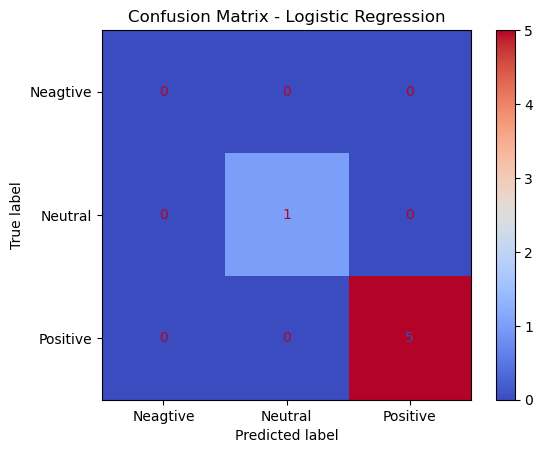

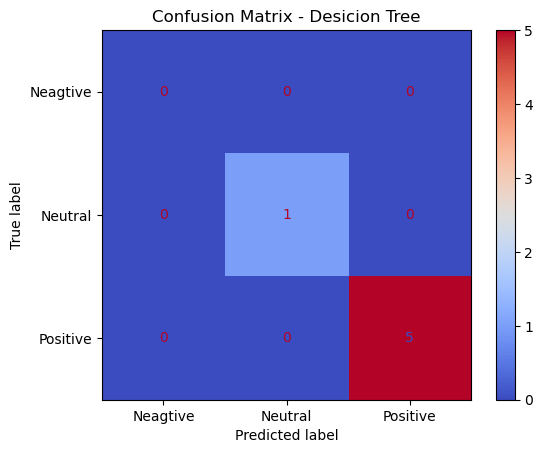

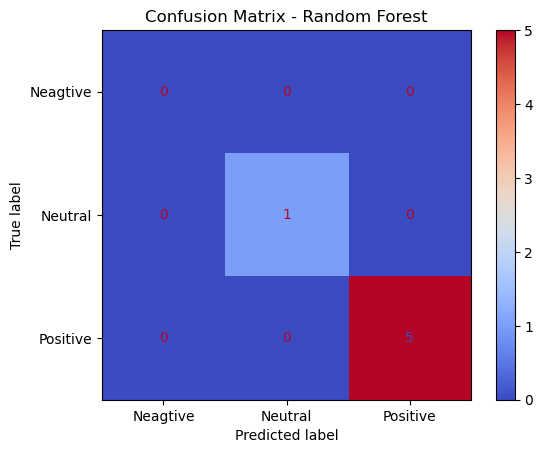

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Loop through models and display confusion matrix
for name, model in models.items():
    y_pred= model.predict(X_test)
    cm=confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neagtive', 'Neutral', 'Positive'])
    disp.plot(cmap='coolwarm')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [33]:
def show_top_words(model, vectorizer, n=10):
    feature_names= vectorizer.get_feature_names_out()
    coefs= model.coef_[0]
    top_positive= sorted(zip(coefs, feature_names))[-n:]
    top_negative= sorted(zip(coefs, feature_names))[n:]
    print("Top Positive Words:")
    for coef, word in reversed(top_positive):
        print(f"{word}: {coef:.4f}")
        print("\nTop Negative Words:")
    for coef, word in top_negative :
        print(f"{word}: {coef:.4f}")
show_top_words(models["Logistic Regression"], tfidf)

Top Positive Words:
ai: 0.3284

Top Negative Words:
https: 0.3055

Top Negative Words:
co: 0.2701

Top Negative Words:
the: 0.2365

Top Negative Words:
ronald_vanloon: 0.2180

Top Negative Words:
available: 0.1883

Top Negative Words:
crypto_colombus: 0.1822

Top Negative Words:
free: 0.1687

Top Negative Words:
pr: 0.1506

Top Negative Words:
use: 0.1487

Top Negative Words:
𝐂𝐨𝐮𝐫𝐬𝐞𝐬: -0.2460
𝐅𝐢𝐫𝐬𝐭: -0.2460
𝐅𝐫𝐞𝐞: -0.2460
𝐏𝐚𝐢𝐝: -0.2460
𝐏𝐞𝐨𝐩𝐥𝐞: -0.2460
𝐟𝐨𝐫: -0.2460
illegal: -0.2260
previous: -0.2248
analyst: -0.2073
gt: -0.2073
sadhna6389: -0.2073
8th: -0.1890
astronomer_zero: -0.1890
back: -0.1890
fomc: -0.1890
hard: -0.1890
june: -0.1890
meetings: -0.1890
pull: -0.1890
still: -0.1890
tim: -0.1890
using: -0.1890
why: -0.1890
wo: -0.1890
ethical: -0.1761
hacking: -0.1761
𝟓𝟎𝟎𝟎: -0.1761
data: -0.1726
analysis: -0.1535
act: -0.1418
ago: -0.1418
bill: -0.1418
data_republican: -0.1418
dizee4: -0.1418
followed: -0.1418
guy: -0.1418
learned: -0.1418
nye: -0.1418
cash: -0.1194
deleting: -0.1194


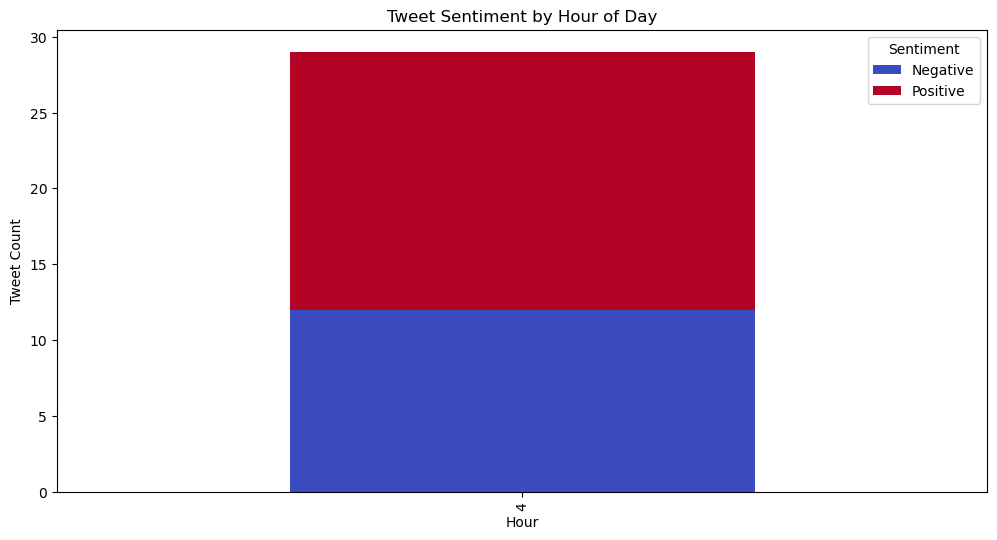

In [51]:
#Check and process if date column exists
if 'Date' in df.columns:
    df['Date']= pd.to_datetime(df['Date'], errors='coerce')
    df['hour']= df['Date'].dt.hour
    if 'Sentiment' in df.columns:
        hourly_sentiment= df.groupby(['hour','Sentiment']).size().unstack().fillna(0)
        hourly_sentiment.plot(kind='bar', stacked= True, figsize=(12,6), colormap= 'coolwarm')
        plt.title("Tweet Sentiment by Hour of Day")
        plt.xlabel("Hour")
        plt.ylabel("Tweet Count")
        plt.show()
    else:
        print("Sentiment column not found")
else:
    print("Date column not found")

In [65]:
#HeatMap: Tweet Frequency by Day and Hour
df['Date']= pd.to_datetime(df['Date'], errors='coerce')
#Extract day of the week and hour of the day
df['Day']= df['Date'].dt.day_name()
df['Hour']= df['Date'].dt.hour
#Create a pivot table : count of tweets by day and hour
heatmap_data= df.pivot_table(index='Day', columns='Hour', values='Content', aggfunc='count').fillna(0)
#Reorder the days for logical view
ordered_days= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data= heatmap_data.reindex(ordered_days)

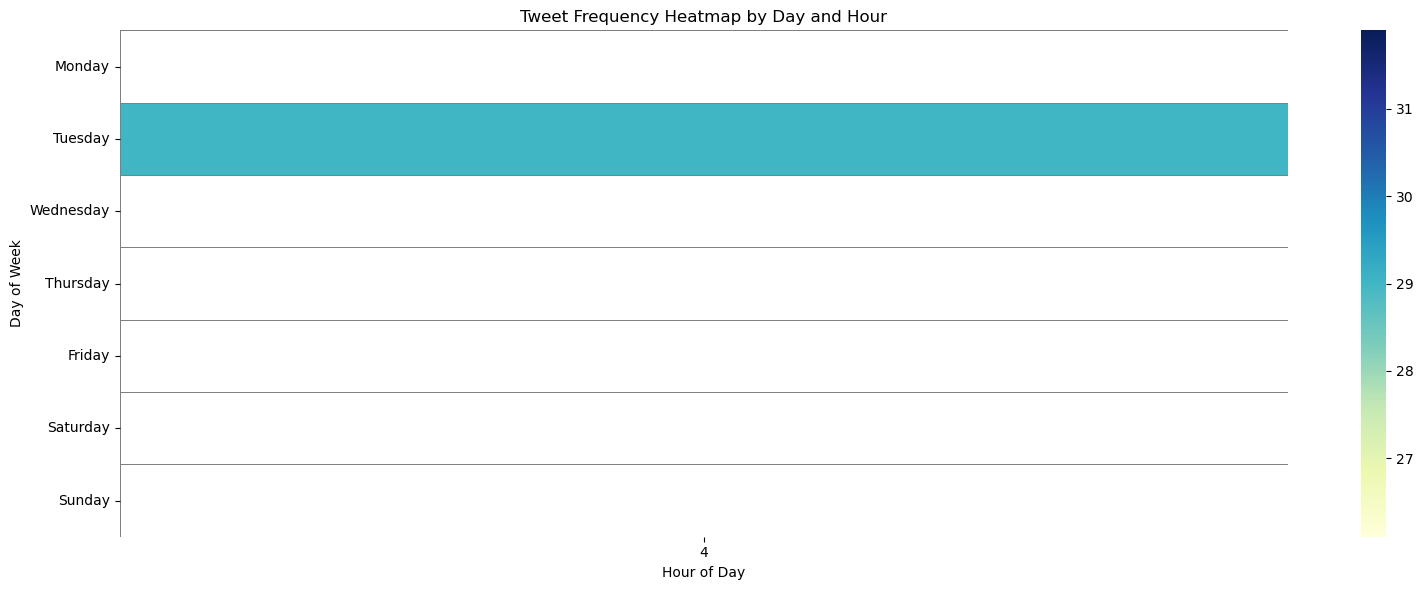

In [55]:
#Plot Heatmap
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidth=.5, linecolor='grey')
plt.title("Tweet Frequency Heatmap by Day and Hour")
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

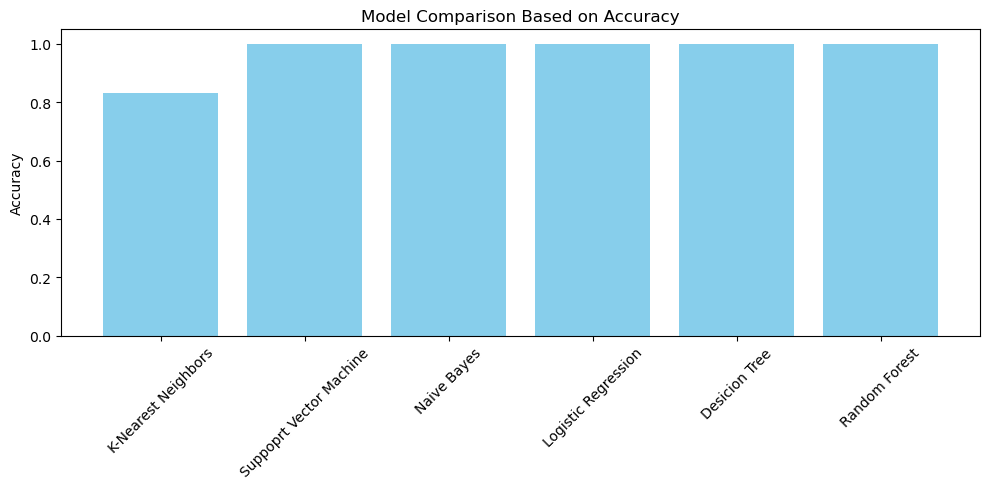

In [67]:
accuracy_scores= {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    accuracy_scores[name]= accuracy_score(y_test, y_pred)

#Bar Plot
plt.figure(figsize=(10,5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.title('Model Comparison Based on Accuracy')
plt.tight_layout()
plt.show()

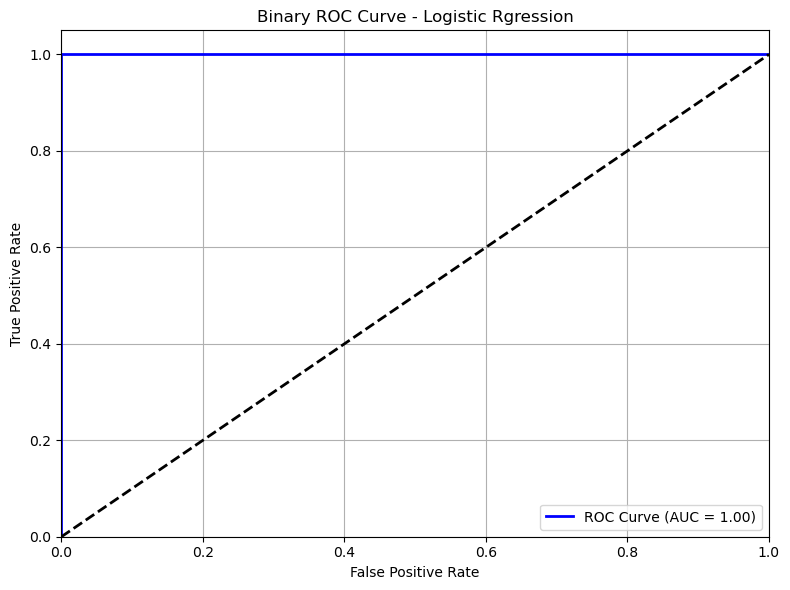

In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
chosen_model = fitted_models['Logistic Regression']
y_score = chosen_model.decision_function(X_test)

#Compute ROC and AUC
fpr, tpr, _ =roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color = 'blue', lw = 2, label = f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - Logistic Rgression')
plt.legend(loc= 'lower right')
plt.grid(True)
plt.tight_layout()
plt.show()